In [ ]:
import torch.nn as nn
from torch.nn import functional as funct
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import os
from PIL import Image
from torch import optim
import torch
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import argparse

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!pip install wget
import wget
wget.download('https://storage.googleapis.com/wandb_datasets/nature_12K.zip')
!unzip /content/nature_12K.zip

Streaming output truncated to the last 5000 lines.
  inflating: inaturalist_12K/train/Arachnida/1ac25349af662e85f577a31f64beca41.jpg  
  inflating: inaturalist_12K/train/Arachnida/117ef7f1812725f359500448a258e713.jpg  
  inflating: inaturalist_12K/train/Arachnida/6409254954c3b46d88d64f0bf4c632fa.jpg  
  inflating: inaturalist_12K/train/Arachnida/aaed865750bd52944658a7dd23366948.jpg  
  inflating: inaturalist_12K/train/Arachnida/460cc09ef510d400a4d47a836ddd45e6.jpg  
  inflating: inaturalist_12K/train/Arachnida/55c48c3afef0b745e53951284cdb2db4.jpg  
  inflating: inaturalist_12K/train/Arachnida/bff3daa961ee96a37ebe12dc0bcce504.jpg  
  inflating: inaturalist_12K/train/Arachnida/9082d4f2107bccf1f14d71c8944be607.jpg  
  inflating: inaturalist_12K/train/Arachnida/93d0130423d42f7c6228150eb95a2a93.jpg  
  inflating: inaturalist_12K/train/Arachnida/051aba6d7bc324bad76bd438ed3cc276.jpg  
  inflating: inaturalist_12K/train/Arachnida/67595af09c015c7753d5d4935677590f.jpg  
  inflating: inaturalist_

In [ ]:
def dataset_loader(image_size , aug_type , batch_size,split_ratio, data_path):

  test_trans = transforms.Compose([transforms.Resize((image_size, image_size)),ransforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

  if(aug_type == 'Yes'):

    train_trans = transforms.Compose([transforms.RandomHorizontalFlip(),transforms.RandomRotation(degrees=30),transforms.Resize((image_size, image_size)),transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

  else:
    train_trans = test_trans

  dataset = data_path
  train = datasets.ImageFolder(os.path.join(dataset, 'train'), transform = train_trans)
  test = datasets.ImageFolder(os.path.join(dataset, 'val'), transform = test_trans)

  class_set = train.classes

  val = 1999
  tr = 9999-val
  train,validation = random_split(train, [tr, val])

  load_train = DataLoader(train, batch_size = batch_size, num_workers=4)
  load_validation = DataLoader(validation, batch_size = batch_size, num_workers=4)
  load_test = DataLoader(test, batch_size = batch_size, num_workers=4)


  return class_set , load_train , load_test ,load_validation


In [ ]:
def train_model(model , settings , class_set , load_train , load_test ,load_validation ):

  def assign_optimizer(opt_type , lr , model):
    if(opt_type  == 'adam'):
      optimizer = optim.Adam(model.parameters(), lr)
      return optimizer
    if(opt_type  == 'sgd'):
      optimizer = optim.SGD(model.parameters(), lr)
      return optimizer

  optimizer = assign_optimizer(settings.optimizer , settings.learning_rate , model)
  criterion = nn.CrossEntropyLoss()

  for epochit in range(settings.epochs):
      temp_loss_train = 0.0
      pred_train = 0
      pred_total = 0


      model.train()

      for images, labels in load_train:

          images = images.to(device)
          labels =  labels.to(device)

          optimizer.zero_grad()
          outputs = model.forward(images)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          temp_loss_train += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          pred_total += labels.size(0)
          pred_train += (predicted == labels).sum().item()


      train_accuracy = pred_train / pred_total
      loss_train = temp_loss_train / len(load_train)
      print('===================================================================================')
      print('Epoch ',epochit+1, "Train Loss:", loss_train, "Train Accuracy:" ,train_accuracy)




      model.eval()
      temp_loss_val = 0.0
      pred_val = 0
      pred_total_val = 0

      with torch.no_grad():
          for val_images, val_labels in load_validation:

              val_images = val_images.to(device)
              val_labels =  val_labels.to(device)
              val_outputs = model.forward(val_images)
              val_loss = criterion(val_outputs, val_labels)
              temp_loss_val += val_loss.item()

              _, val_predicted = torch.max(val_outputs.data, 1)
              pred_total_val += val_labels.size(0)
              pred_val += (val_predicted == val_labels).sum().item()

      val_accuracy = pred_val / pred_total_val
      val_average_loss = temp_loss_val / len(load_validation)
      print("Validation Loss:", val_average_loss, "Validation Accuracy:" ,val_accuracy)
      print('===================================================================================')

  # predicted_labels, class_images,actual_labels= fetch_and_predict(model, load_test)
  # plot_predicted_and_actual(class_images, predicted_labels, actual_labels, load_test.dataset.classes)




In [ ]:
def layer_manage_grad(model ,layer_type , freeze_type , k):


  if(freeze_type == 'all'):

    for param in model.features.parameters():
      param.requires_grad = False
    total_dense_layers = sum(1 for name, _ in model.classifier.named_modules() if isinstance(_, torch.nn.Conv2d))
    for param in model.classifier[:total_dense_layers].parameters():
      param.requires_grad = False

#-----------------------------------------------------------------------------------------
  if(freeze_type == 'allconv'):
    for param in model.features.parameters():
      param.requires_grad = False

  if(freeze_type == 'alldense'):
    total_dense_layers = sum(1 for name, _ in model.classifier.named_modules() if isinstance(_, torch.nn.Conv2d))
    for param in model.classifier[:total_dense_layers].parameters():
      param.requires_grad = False
#-----------------------------------------------------------------------------------------
  if(freeze_type == 'first'):

    if(layer_type == 'conv'):

      for i, (name, param) in enumerate(model.features.named_parameters()):
        if i < k and 'conv' in name:
            param.requires_grad = False
        else:
            break
    if(layer_type == 'dense'):

      for i, (name, param) in enumerate(model.classifier.named_parameters()):
        if i < k and 'Linear' in name:
            param.requires_grad = False
        else:
            break
#-----------------------------------------------------------------------------------------

  if(freeze_type == 'last'):

    if(layer_type == 'conv'):

      total_conv_layers = sum(1 for name, _ in model.features.named_modules() if isinstance(_, torch.nn.Conv2d))

      for i, (name, param) in enumerate(model.features.named_parameters()):
          if total_conv_layers - i <= k and 'conv' in name:
              param.requires_grad = False


    if(layer_type == 'dense'):

      total_dense_layers = sum(1 for name, _ in model.classifier.named_modules() if isinstance(_, torch.nn.Conv2d))

      for i, (name, param) in enumerate(model.classifier.named_parameters()):
          if total_dense_layers - i <= k and 'conv' in name:
              param.requires_grad = False

#------------------------------------------------------------------------------------------


In [ ]:
def fetch_three_images_per_class(test_loader):
    class_images = [[] for _ in range(len(test_loader.dataset.classes))]
    actual_labels = []
    class_image_count = [0] * len(class_images)

    with torch.no_grad():
        for images, labels in test_loader:
            for image, label in zip(images, labels):
                if class_image_count[label] < 3:
                    class_images[label].append(image)
                    actual_labels.append(label)
                    class_image_count[label] += 1

    print(actual_labels)
    return class_images, actual_labels

def predict_labels(model, test_loader):
    model.eval()
    predicted_labels = []
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())
    return predicted_labels

def fetch_and_predict(model, test_loader):
    predicted_labels = predict_labels(model, test_loader)
    class_images,actual_labels = fetch_three_images_per_class(test_loader)
    return predicted_labels, class_images , actual_labels


def plot_predicted_and_actual(class_images, predicted_labels, actual_labels, label_names):
    fig, axs = plt.subplots(10, 3, figsize=(15, 30))
    fig.tight_layout(pad=3.0)

    for i in range(len(class_images)):
        for j in range(3):
            image = class_images[i][j].permute(1, 2, 0)
            predicted_label = label_names[predicted_labels[i * 3 + j]]
            actual_label = label_names[actual_labels[i*3 + j]]
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"Actual: {actual_label} \n Predicted: {predicted_label}", fontsize=10, color='white', backgroundcolor='black', pad=10)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].spines['top'].set_color('none')
            axs[i, j].spines['bottom'].set_color('none')
            axs[i, j].spines['left'].set_color('none')
            axs[i, j].spines['right'].set_color('none')
            axs[i, j].tick_params(axis='both', which='both', length=0)
            axs[i, j].set_aspect('auto')

    plt.show()



Epoch  1 Train Loss: 1.3445123138427735 Train Accuracy: 0.541
[tensor(0), tensor(0), tensor(0), tensor(1), tensor(1), tensor(1), tensor(2), tensor(2), tensor(2), tensor(3), tensor(3), tensor(3), tensor(4), tensor(4), tensor(4), tensor(5), tensor(5), tensor(5), tensor(6), tensor(6), tensor(6), tensor(7), tensor(7), tensor(7), tensor(8), tensor(8), tensor(8), tensor(9), tensor(9), tensor(9)]


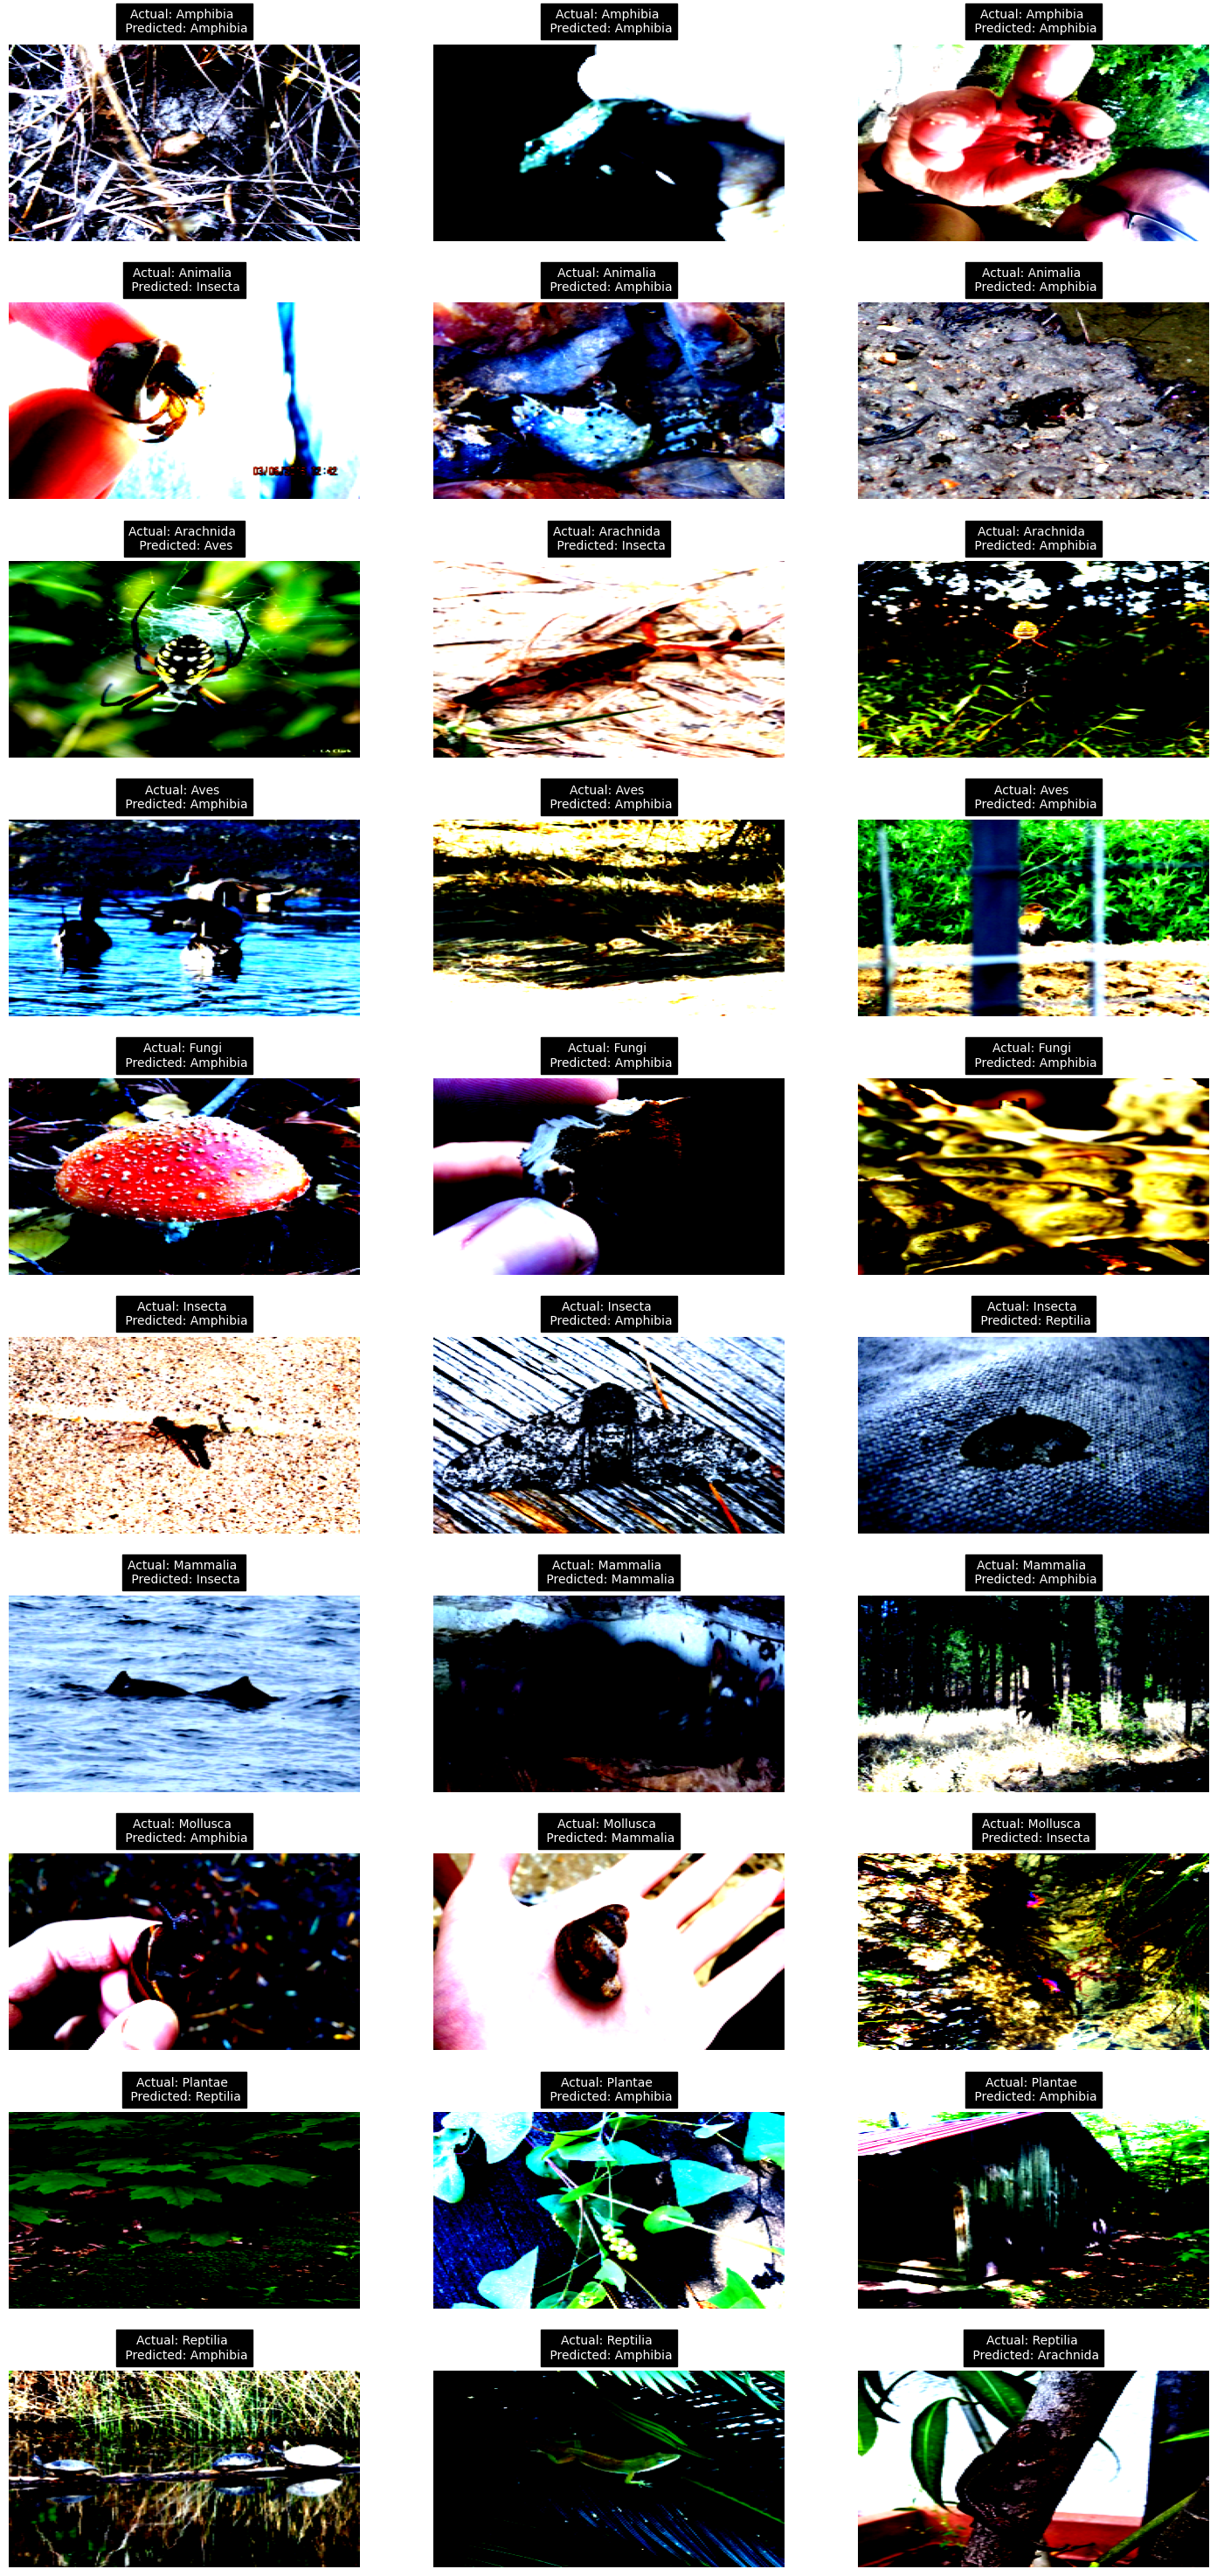

In [ ]:
model = torchvision.models.alexnet(pretrained = True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 10)
model.classifier.add_module("7",nn.LogSoftmax(dim=1))
# print(model)
# summary(model,(3,224,224))
model.to(device)


settings = {
  'data_augmentation' : "No", # "Yes", "No"
  'batch_size' : 32,
  'image_size' : 224,
  'epochs':1,
  'learning_rate' : 0.0001,
  'optimizer' : 'adam',
  'k' = 3, #range of conv and dense layer , works as index if specific else number of layers to be freezed
  'freeze_type' = 'all', #"dense"
  'layer_type' = "first", #all , first , last , allconv , alldense
}


def parse_arguments():
    parser = argparse.ArgumentParser(description="Alexnet Fine tuning")
    parser.add_argument("-ep", "--epochs", type=int, default=10, help="number of epochs")
    parser.add_argument("-k", "--layers_to_freeze", type=int, default=2, choices=range(6), help="Number of layers to freeze")
    parser.add_argument("-ft", "--freeze_type", type=str, default="first", choices=["first", "last", "all", "allconv", "alldense"], help="Layer freezing type")
    parser.add_argument("-lt", "--layer_type", type=str, default="conv", choices=["conv", "dense"], help="type of layer to be freezed for first and last freeze type")
    parser.add_argument("-opt", "--optimizer", type=str, default="adam", choices=["adam", "sgd"], help="Optimizer types")
    parser.add_argument("-lr", "--learning_rate", type=float, default=0.0001, help="Learning rate for the optimizer")
    parser.add_argument("-dp", "--data_path", type=str, default="/kaggle/input/dl-assignment-2-data/inaturalist_12K", help="Path to the data directory")
    parser.add_argument("-bs", "--batch_size", type=int, default=64, help="Batch size for training")
    parser.add_argument("-aug", "--data_augmentation", type=str, default='Yes',choices=["Yes", "No"], help="Data augmentation yes or no")
    return parser.parse_args()




arguments = parse_arguments()

class_set , load_train , load_test ,load_validation = dataset_loader(image_size = 224 , arguments.data_augmentation , arguments.batch_size, 0.125 , arguments.data_path)
layer_manage_grad(model ,arguments.layer_type , arguments.freeze_type , arguments.k)
train_model(model , arguments , class_set , load_train , load_test ,load_validation )